In [1]:
### Display configurations
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
import pandas as pd
from datetime import datetime, timedelta
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates


KEY_STATE, KEY_COUNTRY = "Province_State", "Country_Region"
BASE_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv"
BASE_URL_US = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{}.csv"
def picklecreator(dates, dflist):
    for i, my_df in enumerate(dflist):
        date = dates[i].strftime("%Y-%m-%d")
        my_file = Path(f"../data/gis_data_{date}.pkl")
        if not (my_file.is_file()):
            my_df.to_pickle(f'./data/gis_data_{date}.pkl')
    return 1

def get_df(date):
    base = date - timedelta(days=1)
    date_extension = base.strftime("%Y-%m-%d")
    my_file = Path(f"data/gis_data_{date_extension}.pkl")
    if my_file.is_file():
        df = pd.read_pickle(my_file)
    else:
        d = base.strftime("%m-%d-%Y")
        url = BASE_URL.format(d)
        s = requests.get(url).content
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))
        country_key = KEY_COUNTRY if (KEY_COUNTRY in df.columns) else KEY_COUNTRY.replace("_", "/")
        country_replace = lambda x: "United States" if x == "US" else x
        # TODO: Fix "Korea, South"
        df[country_key] = df[country_key].map(country_replace)
        df.to_pickle(my_file)
    return (base, df)

def get_df_list(year, month, day):
    past = (datetime(year, month, day) - datetime(2020, 11, 1)).days
    date_list = [datetime(year, month, day) - timedelta(days=x) for x in range(past)]
    return [get_df(date) for date in date_list]

def get_counts(df, STATE1, STATE2, attribute):
    if KEY_STATE in df.columns:
        key_state, key_us = KEY_STATE, KEY_COUNTRY
    else:
        key_state, key_us = KEY_STATE.replace("_", "/"), KEY_COUNTRY.replace("_", "/")
    state1_mask, state2_mask, us_mask = df[key_state] == STATE1, df[key_state] == STATE2, df[key_us] == "United States"
    return [df[state1_mask][attribute].sum(), df[state2_mask][attribute].sum(), df[us_mask][attribute].sum()]

def get_perc(c):
    # ca1, ny1, us1, ca2, ny2, us2 = c
    percentages = [(c[3] - c[0]) / c[0], (c[4] - c[1]) / c[1], (c[5] - c[2]) / c[2]]
    return [round(100 * x, 2) for x in percentages]

def get_data(df_list, STATE1, STATE2, attribute="Confirmed"):
    date_counts, date_percs = [], []
    for date, df in df_list:
        c = get_counts(df, STATE1, STATE2, attribute)
        date_counts.append((date, [c[0], c[1], c[2]]))
    for i in range(len(date_counts) - 1, 0, -1):
        perc = get_perc(date_counts[i][1] + date_counts[i - 1][1])
        date_percs.append((date_counts[i-1][0], perc))
    state1 = [p[1][0] for p in date_percs], [c[1][0] for c in date_counts[1:]]
    state2 = [p[1][1] for p in date_percs], [c[1][1] for c in date_counts[1:]]
    us = [p[1][2] for p in date_percs], [c[1][2] for c in date_counts[1:]]
    return state1, state2, us

def plot_one_line(time_data, y, ylabel):
    fig, ax = plt.subplots(1, figsize=(10,4))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))        
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.plot_date(time_data, y, 'b-');
    ax.set_ylabel(ylabel)
    return

def perc_count_pairs(time_data, y_data, attribute):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(13,8))
    zipped = [[(ax1, p), (ax2, c)] for (p, c) in y_data]
    for (ax1, y1), (ax2, y2) in zipped:
        delta = timedelta(days=1)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))        
        ax1.set_xlim([min(time_data) - delta, max(time_data) + delta])
        ax1.plot_date(time_data, y1);
        ax1.set_ylabel(f"day-over-day increase of {attribute}")
        ax2.set_ylabel(f"Number of {attribute}")
        ax2.plot_date(time_data, y2);
        legend = (f"{STATE1}", f"{STATE2}", "United States")
        ax1.legend(legend)
        ax2.legend(legend)

def get_all_states(df):
    all_states = list(set(df[df["Country_Region"] == "United States"]["Province_State"]))
    all_states.remove("Diamond Princess")
    all_states.remove("Grand Princess")
    all_states.remove("Guam")
    all_states.remove("Northern Mariana Islands")
    all_states.remove("Recovered")
    all_states.remove("Virgin Islands")
    all_states.remove("Puerto Rico")
    all_states.remove("District of Columbia")
    df_pop = pd.read_csv("data/nst-est2019-alldata.csv")
    df_pop = df_pop[df_pop.NAME.isin(all_states)]
    state_pop = dict(df_pop[["NAME", "POPESTIMATE2018"]].values)
    return all_states, state_pop

def group_per_df(gis_data, attribute="Confirmed"):
    grouped_state_df_list = []
    for date, df in gis_data:
        key = KEY_STATE if KEY_STATE in df.columns else KEY_STATE.replace("_", "/")
        state_df = df[df[key].isin(all_states)]
        grouped_state_df = state_df[[key, attribute]].groupby(key).sum().reset_index()
        grouped_state_df["population"] = [state_pop[x] for x in grouped_state_df[key]]
        grouped_state_df["capita_per_mil"] = round(1000000 * grouped_state_df[attribute] / grouped_state_df["population"], 3)
        grouped_state_df["1_in_x"] = round(grouped_state_df["population"] / grouped_state_df[attribute])
        grouped_state_df.sort_values(by="capita_per_mil", ascending=False, inplace=True)
        grouped_state_df_list.append((date, grouped_state_df))
    return grouped_state_df_list

def get_state_csv(grouped_state_df_list, all_states, metric="capita_per_mil"):
    N = len(grouped_state_df_list)
    all_dates = [grouped_state_df_list[i][0].strftime("%b %d, %Y") for i in range(N)]
    count_dict = [{"state": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    state_party_dict = get_state_party()
    state_dict = {s: {"state": s, 'party': state_party_dict[s]} for s in all_states}
    # party_dict = {s: {"party": state_party_dict[s]} for s in all_states}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in state_dict.values()]

    for i in range(N):
        date_string = grouped_state_df_list[i][0].strftime("%b %d, %Y")
        key = KEY_STATE if (KEY_STATE in grouped_state_df_list[i][1].columns) else KEY_STATE.replace("_", "/")
        df_temp = grouped_state_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for state, count in data_list:
            state_dict[state][date_string] = count
    return state_dict

def save_flag_csv(my_dict, all_states, metric="state_rate"):
    my_df = pd.DataFrame(my_dict.values())
    old_columns = list(my_df.columns)
    base_flag_url = 'https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/images/flags/{state_name}-large.png'
    my_df['url'] = [base_flag_url.format(state_name=state.replace(" ", "-").lower()) for state in all_states]
    my_df = my_df[[old_columns[0], 'url'] + old_columns[1:]]
    my_df.to_csv(r'{metric}_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_data.csv at " + datetime.strftime(datetime.now(), format="%I:%M:%S %p"))
    
%matplotlib inline

def get_deltas(y):
    return [max(y[i+1] - y[i], 0) for i in range(len(y) - 1)]

def get_rolling_avg(y, N):
    return [sum([y[i - k] for k in range(N)]) / N for i in range(N-1, len(y))]

def plot_four_bar(time_data, y, ylabel):
    fig, ax = plt.subplots(1, figsize=(12,7))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.xaxis_date()
    ax.bar(time_data, y, width=1.0, edgecolor='w');
    ax.set_ylabel(ylabel)
    return

def plot_one_bar(time_data, y, roll_avg, N, ylabel):
    fig, ax = plt.subplots(1, figsize=(16,7))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.xaxis_date()
    ax.plot(time_data, roll_avg, c='r', label=r"{N}d avg".format(N=N))
    ax.set_ylabel(ylabel)
    ax.legend(shadow=True, fancybox=True)    
    ax.bar(time_data, y, width=1.0, edgecolor='w', color='cornflowerblue');
    ax.set_ylabel(ylabel)
    return

def get_data_level(level):
    if level == "county": return "Admin2"
    elif level == "state": return "Province_State"
    else: return "Country_Region"

def get_covid_attribute(y_t, level="county", region="San Francisco", attribute="Confirmed", N=7):
    n, y = len(y_t), []
    for i in range(n):
        df = gis_data[n - 1 - i][1]
        data_level = get_data_level(level)
        if data_level not in df.columns:
            data_level = data_level.replace("_", "/")
        attribute = attribute.strip().title()
        y.append(sum(df[df[data_level] == region][attribute].values))
    delta_y = get_deltas(y)
    return delta_y[N-1:], get_rolling_avg(delta_y, N)

def get_region_data(region_list, level="state", attribute="Confirmed"):
    num_regions, y_t, N = len(region_list), time_data[:-5][::-1], 7
    bar_list, roll_avg_list = [[] for __ in range(num_regions)], [[] for __ in range(num_regions)]
    for i in range(num_regions):
        bar_list[i], roll_avg_list[i] = get_covid_attribute(y_t, level, region_list[i], attribute, N)
    return y_t[N:], bar_list, roll_avg_list
        
def plot_region_data(y_t, bar_list, roll_avg_list, region_list, attribute="Confirmed"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8), sharex='all')
    if attribute == "Confirmed":
        ylabel = " New Cases" 
    else:
        ylabel = " Deaths"
    for i, ax in enumerate([ax1, ax2, ax3, ax4]):
        ax.bar(y_t, bar_list[i], width=1.0, color='cornflowerblue', edgecolor='w')
        ax.plot(y_t, roll_avg_list[i], c='r', label=r"{N}d avg".format(N=N))
        ax.set_ylabel(region_list[i] + ylabel)
        ax.legend(shadow=True, fancybox=True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    fig.suptitle(f"COVID-19 {attribute}", y=1.01)
    fig.tight_layout()
    
def plot_daily(time_data, y, label, attribute="Confirmed"):
    n = len(y)
    increases = []
    for i in range(n - 1):
        diff = y[i+1] - y[i]
        increases.append(diff / y[i] * 100)
    print(f"Avg daily increase {attribute}", round(sum(increases) / len(increases), 4))
    plot_one_line(time_data[::-1][1:], increases, f"{label} Daily % Increase {attribute}")    
    
def get_country_or_state_count(time_data, level="country", state="", attribute="Confirmed"):
    count = []
    for i in range(len(time_data)):
        if level == "country":
            key = KEY_COUNTRY if KEY_COUNTRY in gis_data[i][1].columns else KEY_COUNTRY.replace("_", "/")
            level_mask = gis_data[i][1][key] == "United States"
        elif level == "state":
            key = KEY_STATE if KEY_STATE in gis_data[i][1].columns else KEY_STATE.replace("_", "/")
            level_mask = gis_data[i][1][key] == state
        date_sum = sum(gis_data[i][1].loc[level_mask, attribute].values)
        count.append(date_sum)
    return count[::-1]

def get_state_party():
    f = open("./state-2016-vote.txt")
    txt = f.read()
    f.close()
    state_party_dict = {}
    state_party = [s.split("\t") for s in txt.split("\n")]
    for state, party in state_party:
        state_party_dict[state] = party    
    return state_party_dict

In [29]:
gis_data = get_df_list(2021, 8, 18)

In [30]:
time_data = [date for date, _ in gis_data[0:-1:]]
print(time_data[0])
gis_data[0][1].head()

2021-08-17 00:00:00


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-08-18 04:21:35,33.93911,67.709953,152243,7031,NaN,NaN,Afghanistan,391.085251,4.618275
1,NaN,NaN,NaN,Albania,2021-08-18 04:21:35,41.15330,20.168300,136598,2468,NaN,NaN,Albania,4746.611995,1.806761
2,NaN,NaN,NaN,Algeria,2021-08-18 04:21:35,28.03390,1.659600,188663,4867,NaN,NaN,Algeria,430.236061,2.579732
3,NaN,NaN,NaN,Andorra,2021-08-18 04:21:35,42.50630,1.521800,14960,129,NaN,NaN,Andorra,19361.936194,0.862299
4,NaN,NaN,NaN,Angola,2021-08-18 04:21:35,-11.20270,17.873900,44972,1118,NaN,NaN,Angola,136.833303,2.485991


In [31]:
# # Bay Area numbers
i = 0
key_state = KEY_STATE if KEY_STATE in gis_data[i][1].columns else KEY_STATE.replace("_", "/")
state_mask = gis_data[i][1][key_state] == "California"
counties = gis_data[i][1][state_mask]["Admin2"].unique()
bay_area = ['Alameda', 'Contra Costa', 'Marin', 'Mendocino', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Santa Cruz', 'Sonoma', 'Solano']
county_mask = gis_data[0][1]["Admin2"].isin(bay_area)
gis_data[0][1][county_mask & state_mask]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
849,6001.0,Alameda,California,United States,2021-08-18 04:21:35,37.646294,-121.892927,102751,1305,NaN,NaN,"Alameda, California, US",6147.861971,1.270061
855,6013.0,Contra Costa,California,United States,2021-08-18 04:21:35,37.919235,-121.928953,82850,848,NaN,NaN,"Contra Costa, California, US",7182.326189,1.023537
869,6041.0,Marin,California,United States,2021-08-18 04:21:35,38.071225,-122.721063,15717,239,NaN,NaN,"Marin, California, US",6072.419309,1.520646
871,6045.0,Mendocino,California,United States,2021-08-18 04:21:35,39.438119,-123.391131,5332,55,NaN,NaN,"Mendocino, California, US",6146.468547,1.031508
876,6055.0,Napa,California,United States,2021-08-18 04:21:35,38.507358,-122.332839,11021,83,NaN,NaN,"Napa, California, US",8001.074457,0.753108
886,6075.0,San Francisco,California,United States,2021-08-18 04:21:35,37.752151,-122.438567,44681,570,NaN,NaN,"San Francisco, California, US",5068.464714,1.275710
889,6081.0,San Mateo,California,United States,2021-08-18 04:21:35,37.422881,-122.327555,47024,592,NaN,NaN,"San Mateo, California, US",6134.314671,1.258932
891,6085.0,Santa Clara,California,United States,2021-08-18 04:21:35,37.231049,-121.697046,128862,1773,NaN,NaN,"Santa Clara, California, US",6684.226797,1.375890
892,6087.0,Santa Cruz,California,United States,2021-08-18 04:21:35,37.055803,-122.006652,17497,209,NaN,NaN,"Santa Cruz, California, US",6404.160856,1.194490
896,6095.0,Solano,California,United States,2021-08-18 04:21:35,38.268274,-121.935711,37914,263,NaN,NaN,"Solano, California, US",8469.695717,0.693675


7d rolling average on Aug 17, 2021: 137534
total confirmed: 10033826


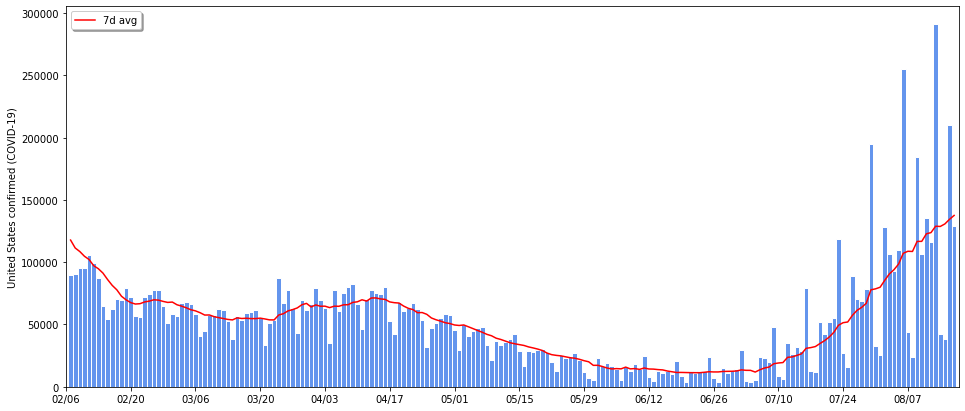

In [51]:
y_t = time_data[:-90][::-1]
level, attribute, region, N = "country", " confirmed", "United States", 7
# level, region, attribute, N = "state", "Florida", " deaths", 7
# level, region, attribute, N = "state", "Texas", " deaths", 7
data, roll_avg = get_covid_attribute(y_t, level, region, attribute, N)
print(f"7d rolling average on {y_t[-1].strftime('%b %d, %Y')}: {int(roll_avg[-1])}")
print(f"total{attribute}:", sum(data))
plot_one_bar(y_t[N:], data, roll_avg, N, region + attribute + " (COVID-19)");

7d rolling average on Aug 17, 2021: 16000
total confirmed: 897961


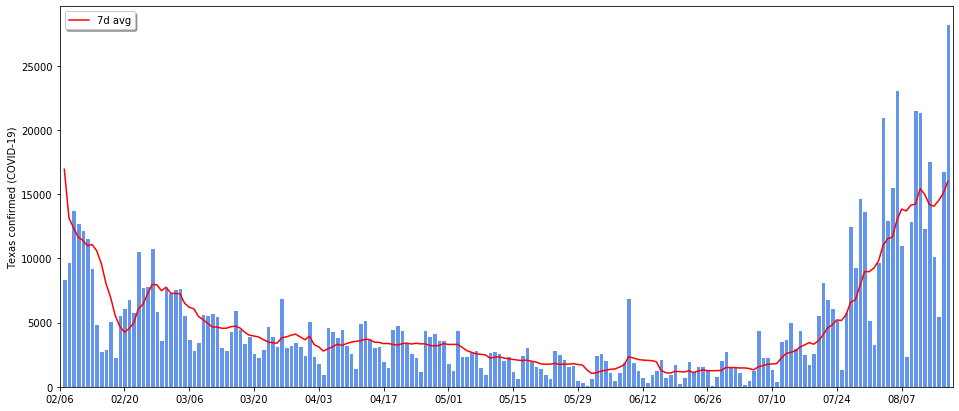

In [47]:
y_t = time_data[:-90][::-1]
level, region, attribute, N = "state", "Texas", " confirmed", 7
data, roll_avg = get_covid_attribute(y_t, level, region, attribute, N)
print(f"7d rolling average on {y_t[-1].strftime('%b %d, %Y')}: {int(roll_avg[-1])}")
print(f"total{attribute}:", sum(data))
plot_one_bar(y_t[N:], data, roll_avg, N, region + attribute + " (COVID-19)");

August 17: San Francisco 202 San Mateo 140 Santa Clara 336 Alameda 366


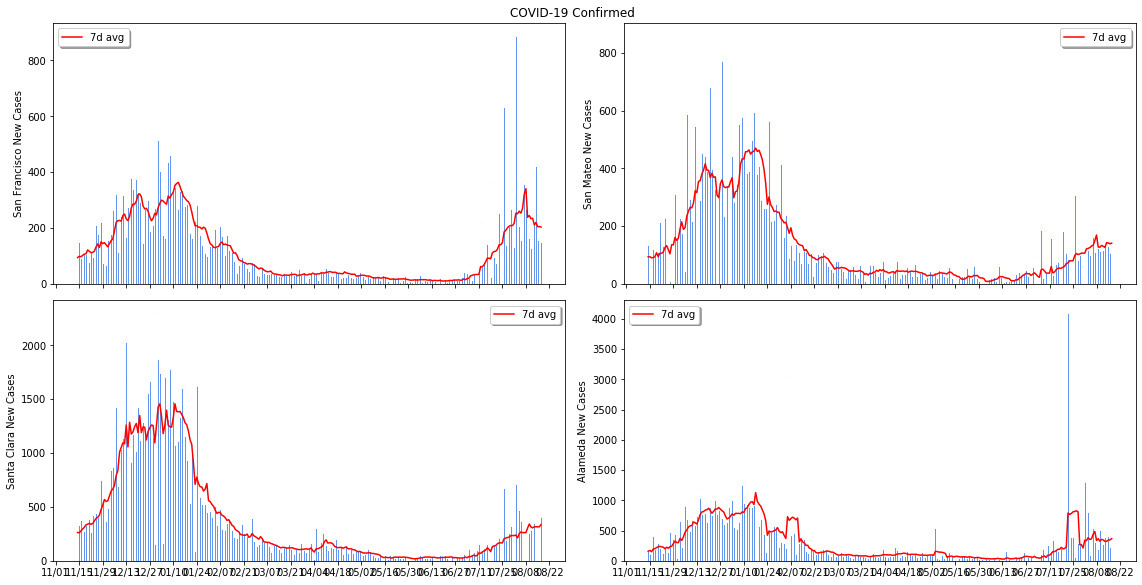

In [48]:
level, attribute, region_list = "county", "Confirmed", ["San Francisco", "San Mateo", "Santa Clara", "Alameda"]
# level, attribute, region_list = "state", "Confirmed", ["Georgia", "Texas", "Florida", "Louisiana"]
y_t, bar_list, roll_avg_list = get_region_data(region_list, level, attribute)
plot_region_data(y_t, bar_list, roll_avg_list, region_list, attribute)
print(y_t[-1].strftime("%B %d") + ": " + " ".join([reg + " " + str(int(ra[-1])) for reg, ra in zip(region_list, roll_avg_list)]))

In [35]:
# state = "California"
# state_count = get_country_or_state_count(time_data, "state", state)
# country_count = get_country_or_state_count(time_data, "country")
# plot_one_line(time_data[::-1], country_count, ylabel="United States Cumulative Cases")
# plot_one_line(time_data[::-1], state_count, ylabel=f"{state} Cumulative cases")

Avg daily increase Confirmed 0.1272


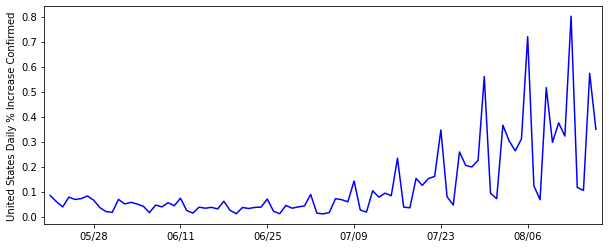

In [36]:
lookback = -(len(time_data) - 90)
region, attribute, t = "United States", "Confirmed", time_data[:lookback]
plot_daily(t, get_country_or_state_count(t, "country", region, attribute), region, attribute)

In [37]:
# STATE1, STATE2 = "South Dakota", "North Dakota"
# perc_count_pairs(time_data, get_data(gis_data, STATE1, STATE2)[:-1], attribute="Deaths")

# Get state per capita data

In [38]:
# add party
state_party_dict = get_state_party()
all_states, state_pop = get_all_states(gis_data[0][1])
grouped_state_df_list = group_per_df(gis_data)
n = len(grouped_state_df_list)
for i in range(n):
    if KEY_STATE in grouped_state_df_list[i][1].columns:
        key_state = KEY_STATE
    else:
        key_state = KEY_STATE.replace("_", "/")
    grouped_state_df_list[i][1]['party'] = grouped_state_df_list[i][1][key_state].map(state_party_dict)

In [39]:
rate_dict = get_state_csv(grouped_state_df_list, all_states, "capita_per_mil")
save_flag_csv(rate_dict, all_states, "state_rate")
count_dict = get_state_csv(grouped_state_df_list, all_states, "Confirmed")
save_flag_csv(count_dict, all_states, "state_cases")

saved to state_rate_data.csv at 11:39:50 PM
saved to state_cases_data.csv at 11:39:50 PM


In [40]:
grouped_state_df_list[-1][1].head()

,Province_State,Confirmed,population,capita_per_mil,1_in_x,party
33,North Dakota,45043,758080,59417.212,17.0,Republican
40,South Dakota,47324,878698,53856.957,19.0,Republican
14,Iowa,130974,3148618,41597.298,24.0,Republican
48,Wisconsin,241422,5807406,41571.400,24.0,Republican
23,Mississippi,120500,2981020,40422.406,25.0,Republican


In [41]:
# save_flag_csv
grouped_state_df_list = group_per_df(gis_data, "Deaths")
rate_dict = get_state_csv(grouped_state_df_list, all_states, "capita_per_mil")
save_flag_csv(rate_dict, all_states, "state_death_rate")
count_dict = get_state_csv(grouped_state_df_list, all_states, "Deaths")
save_flag_csv(count_dict, all_states, "state_death_counts")

saved to state_death_rate_data.csv at 11:39:52 PM
saved to state_death_counts_data.csv at 11:39:53 PM


In [42]:
grouped_state_df_list[30][1].head()

,Province_State,Deaths,population,capita_per_mil,1_in_x
29,New Jersey,26539,8886025,2986.600,335.0
31,New York,53566,19530351,2742.705,365.0
20,Massachusetts,18020,6882635,2618.183,382.0
38,Rhode Island,2736,1058287,2585.310,387.0
2,Arizona,18117,7158024,2531.006,395.0


In [43]:
x = grouped_state_df_list[0][1][["Province_State", "capita_per_mil"]]
x.reset_index(inplace=True, drop=True)
print(time_data[0])
x

2021-08-17 00:00:00


,Province_State,capita_per_mil
0,New Jersey,3006.406
1,New York,2771.891
2,Mississippi,2643.391
3,Massachusetts,2637.653
4,Rhode Island,2595.704
5,Arizona,2579.902
6,Louisiana,2512.184
7,Alabama,2420.780
8,South Dakota,2340.964
9,Connecticut,2325.060


In [44]:
# STATE1, STATE2 = "Arkansas", "Mississippi"
# y = get_data(gis_data, STATE1, STATE2)[:-1] # y[0] = counts, y[1] = daily_increase
# rates = list(rate_dict[STATE1].values())[1:], list(rate_dict[STATE2].values())[1:]
# rates
# perc_count_pairs(time_data, y)
# top5, q = list(x["Province_State"].values[:5]), list(rate_dict.items())
# [list(q[i][1].items()) for i in range(50) if q[i][0] in top20]

# Country cases per capita

In [45]:
gis_data[0][1]['Country_Region']

def get_all_countries(df):
    all_countries = set(gis_data[0][1]['Country_Region'])
    df_pop = pd.read_csv("data/prb-2019.csv")
    df_pop = df_pop.loc[df_pop["Type"] == "Country"][["FIPS", "Name", "Data"]]
    # make country code dict to get two letter codes; e.g. US, CA, etc.
    # https://github.com/google/region-flags/tree/gh-pages/png
    url = "https://raw.githubusercontent.com/google/region-flags/gh-pages/png/{code}.png"
    df_pop["url"] = [url.format(code=c) for c in df_pop["FIPS"].values]
    df_pop.drop(["FIPS"], axis=1, inplace=True)
    df_pop = df_pop[["Name", "url", "Data"]]
    df_pop.columns = ["country", "url", "data"]
    df_pop.sort_values(by="data", inplace=True)
    df_pop = df_pop[df_pop["data"] >= 5]
    world_countries = set(df_pop["country"].unique())
    both = world_countries.intersection(all_countries)
    df_pop = df_pop[df_pop["country"].isin(both)]
    world_pop = dict(df_pop[["country", "data"]].values)
    country_url = dict(df_pop[df_pop["country"].isin(both)][["country", "url"]].values)
    return both, world_pop, country_url

def group_per_df_country(gis_data, attribute="Confirmed"):
    all_countries, world_pop, country_url = get_all_countries(gis_data[0][1])
    grouped_country_df_list = []
    for date, df in gis_data:
        key = KEY_COUNTRY if KEY_COUNTRY in df.columns else KEY_COUNTRY.replace("_", "/")
        country_df = df[df[key].isin(all_countries)]
        grouped_country_df = country_df[[key, attribute]].groupby(key).sum().reset_index()
        grouped_country_df["population"] = [int(world_pop[x] * 1000000) for x in grouped_country_df[key]]
        grouped_country_df["capita"] = round(1000000 * grouped_country_df[attribute] / grouped_country_df["population"], 3)
        grouped_country_df.sort_values(by="capita", ascending=False, inplace=True)
        grouped_country_df["url"] = [country_url[country] for country in grouped_country_df[key]]
        grouped_country_df_list.append((date, grouped_country_df))
    return grouped_country_df_list, all_countries, country_url

def get_csv(grouped_country_df_list, all_countries, country_url, metric="capita"):
    N = len(grouped_country_df_list)
    all_dates = [grouped_country_df_list[i][0].strftime("%b %d, %Y") for i in range(N)]
    count_dict = [{"country": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    country_dict = {c: {"country": c, "url": u} for c, u in country_url.items()}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in country_dict.values()]

    for i in range(N):
        date_string = grouped_country_df_list[i][0].strftime("%b %d, %Y")
        key = KEY_COUNTRY if (KEY_COUNTRY in grouped_country_df_list[i][1].columns) else KEY_COUNTRY.replace("_", "/")
        df_temp = grouped_country_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for country, count in data_list:
            country_dict[country][date_string] = count
    return country_dict

def save_csv(my_dict, metric="capita"):
    my_df = pd.DataFrame(my_dict.values())
    my_df.to_csv(r'{metric}_country_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_country_data.csv at " + datetime.strftime(datetime.now(), format="%I:%M:%S %p"))

grouped_country_df_list, all_countries, country_url = group_per_df_country(gis_data)
metric = "capita"
country_dict = get_csv(grouped_country_df_list, all_countries, country_url, metric)
country_dict.pop('China')
save_csv(country_dict, metric)
metric = "Confirmed"
count_country_dict = get_csv(grouped_country_df_list, all_countries, country_url, 'Confirmed')
count_country_dict.pop('China')
save_csv(count_country_dict, "Confirmed")

saved to capita_country_data.csv at 11:39:55 PM
saved to Confirmed_country_data.csv at 11:39:56 PM


In [46]:
grouped_country_df_list[0]

(datetime.datetime(2021, 8, 17, 0, 0),
     Country_Region  Confirmed  population      capita  \
 26         Czechia    1676518    10670000  157124.461   
 3        Argentina    5096443    44938999  113408.022   
 106  United States   37017741   329153000  112463.629   
 47          Israel     956310     8519000  112256.133   
 66     Netherlands    1939614    17335000  111890.049   
 ..             ...        ...         ...         ...   
 19            Chad       4984    16350000     304.832   
 110          Yemen       7347    29162000     251.937   
 68           Niger       5734    23311000     245.978   
 21           China     106602  1398030000      76.252   
 97        Tanzania       1367    58005000      23.567   
 
                                                    url  
 26   https://raw.githubusercontent.com/google/regio...  
 3    https://raw.githubusercontent.com/google/regio...  
 106  https://raw.githubusercontent.com/google/regio...  
 47   https://raw.githubusercon